In [1]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from eggman.grid import luminosity, log_surface_gravity, calculate_eep
from eggman.grid.defaults import MASS, YINI, ZINI, AGE, TEFF, RAD, DNUF, AMLT

import tensorflow as tf

print(f"Using TensorFlow {tf.__version__}")

DIR = "/mnt/data-storage/stellar-emulator/train"
FILENAME = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"

RSTATE = 0
EEP = "EEP"
PHASE = "phase"
LUM = "L"
GRAV = "g"
LOG = "log"
SEP = "_"

UNITS = 128
LAYERS = 7
ACTIV = "elu"
LRATE = 1e-3
BETA1 = 0.9
BETA2 = 0.999
LOSS = "mean_squared_error"
BATCH_SIZE = 65536   # 65536 corresponds to about 1000 epochs in 10 mins
MAX_EPOCHS = 100000  # about 17 hours
SHUFFLE = True
# PATIENCE = 100
# MIN_DELTA = 1e-8  # min change after PATIENCE epochs

print(f"Loading grid data from '{FILENAME}'.")
tracks = pd.read_hdf(FILENAME, "tracks")
stars = pd.read_hdf(FILENAME, "stars")
data = tracks.join(stars).dropna().reset_index()
data.head()

2023-06-28 17:20:49.916506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 17:20:50.373673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow 2.12.0
Loading grid data from '/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5'.


,track,star,star_mass,Yinit,Zinit,amlt,fov_core,fov_shell,star_age,radius,Teff,center_h1,log_LHe,log_Lnuc,Dnu_freq_o,eps_o,delta_Pg
0,7000,1,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.220454e+07,0.893151,6382.509287,0.718192,-45.291905,0.078416,148.565794,1.129515,0.0
1,7000,2,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.300916e+07,0.891027,6377.312552,0.718122,-45.308912,0.077135,149.148739,1.131800,0.0
2,7000,3,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,2.397470e+07,0.890320,6373.785487,0.718037,-45.328570,0.075916,149.362908,1.132830,0.0
3,7000,4,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.019433e+07,0.893682,6371.412400,0.717474,-45.392646,0.075178,148.552167,1.130613,0.0
4,7000,5,0.92329,0.279311,0.001829,1.608258,0.0,0.006041,3.259691e+07,0.894573,6371.453759,0.717253,-45.402736,0.075810,148.331713,1.129892,0.0


In [2]:
print("Preprocessing data.")
# Create log10 quantities
for key in [ZINI, AGE, TEFF, RAD, DNUF]:
    data[SEP.join([LOG, key])] = np.log10(data[key])

data[SEP.join([LOG, GRAV])] = log_surface_gravity(data)
data[SEP.join([LOG, LUM])] = np.log10(luminosity(data))

# Drop bad tracks
with open("../notebook/central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

data = data.drop(index=data[data.track.isin(bad)].index)

print("Calculating EEP.")
# Add EEP and drop pre-MS and post log_g cutoff
keys = [SEP.join([LOG, key]) for key in [AGE, TEFF, LUM]]
primary, secondary = calculate_eep(data, keys)
data[PHASE] = primary
data[EEP] = secondary

data = data.drop(index=data[data.phase == -1].index)

print("Preparing train and test dataset.")
train = data.sample(frac=0.8, random_state=RSTATE)
test = data.drop(index=train.index)

# Separate features and labels
features = [EEP, MASS, YINI, SEP.join([LOG, ZINI]), AMLT]
labels = [SEP.join([LOG, key]) for key in [AGE, TEFF, RAD, DNUF]]
num_features, num_labels = len(features), len(labels)

train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

Preprocessing data.
Calculating EEP.
Preparing train and test dataset.


In [3]:
project_name = "20230628-155230"
model = tf.keras.models.load_model(os.path.join(DIR, project_name, "best_model.tf"))

2023-06-28 17:22:39.906735: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 496 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-06-28 17:22:39.907135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 17841 MB memory:  -> device: 1, name: NVIDIA RTX A4500, pci bus id: 0000:61:00.0, compute capability: 8.6


In [5]:
with tf.device('/gpu:1'):
    test_pred = pd.DataFrame(model(test_features), columns=test_labels.columns, index=test_labels.index)
test_pred.head()

2023-06-28 17:26:19.390173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


,log_star_age,log_Teff,log_radius,log_Dnu_freq_o
7,7.714505,3.808658,-0.048766,2.175772
22,8.868967,3.805767,-0.034103,2.147928
24,8.924950,3.806247,-0.031970,2.144176
25,8.952832,3.806481,-0.030863,2.142268
30,9.068253,3.807140,-0.026696,2.135079


In [6]:
log_error = test_pred - test_labels
error = 10**test_pred - 10**test_labels

In [22]:
sample = test_labels.sample(10000)

Text(0, 0.5, 'log(L/Lsun)')

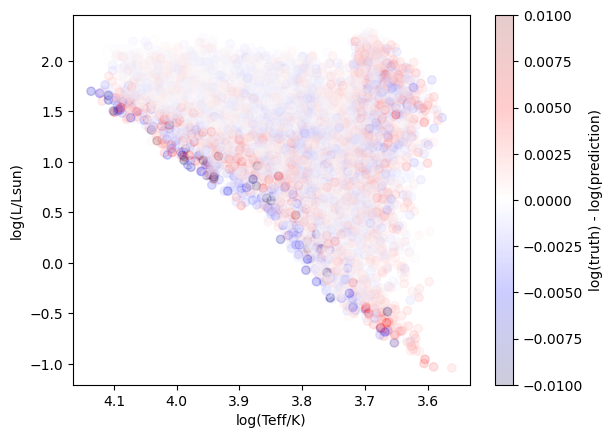

In [23]:
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.01, vmax=0.01)
fig.colorbar(s, label="log(truth) - log(prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

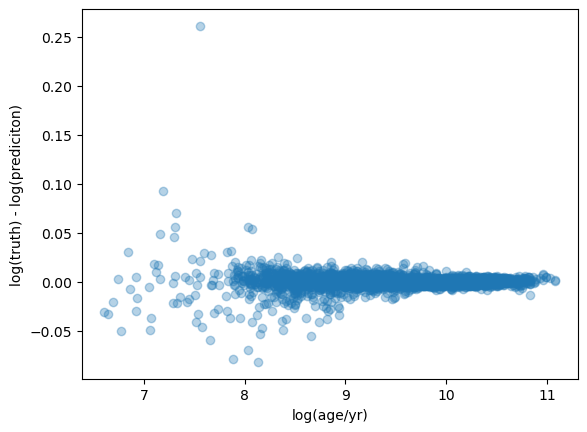

In [24]:
key = "log_star_age"

fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(age/yr)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

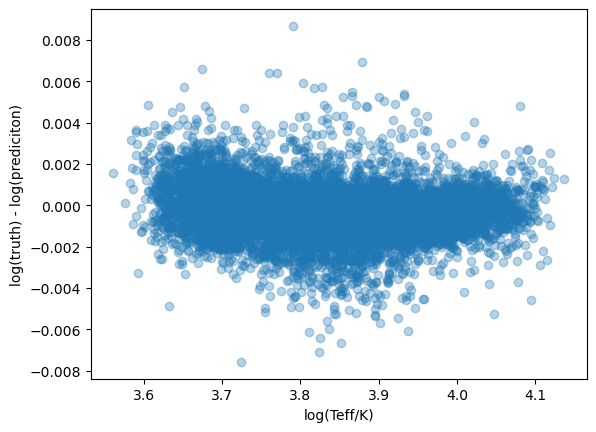

In [25]:
key = "log_Teff"
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

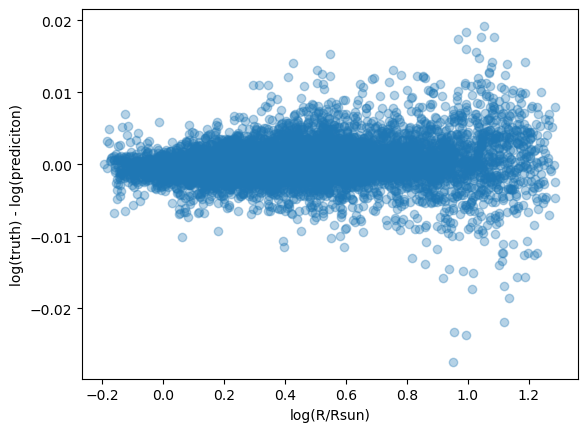

In [26]:
key = "log_radius"
fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(R/Rsun)")
ax.set_ylabel("log(truth) - log(prediciton)")

Text(0, 0.5, 'log(truth) - log(prediciton)')

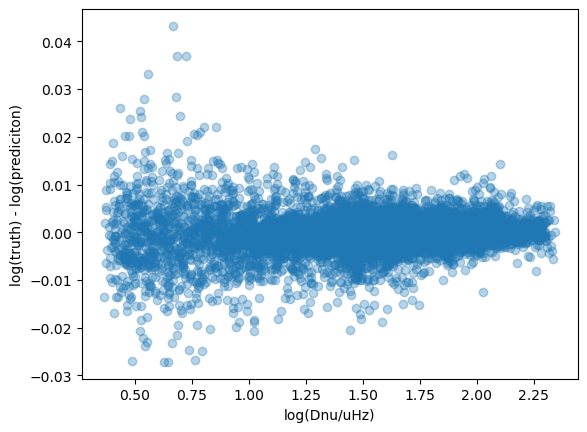

In [27]:
key = "log_Dnu_freq_o"

fig, ax = plt.subplots()
s = ax.scatter(sample[key], log_error.loc[sample.index, key], alpha=0.33)

ax.set_xlabel("log(Dnu/uHz)")
ax.set_ylabel("log(truth) - log(prediciton)")

In [35]:
test_pred["radius"] = 10**test_pred["log_radius"]
test_pred["Teff"] = 10**test_pred["log_Teff"]

test_pred["log_L"] = np.log10(luminosity(test_pred))

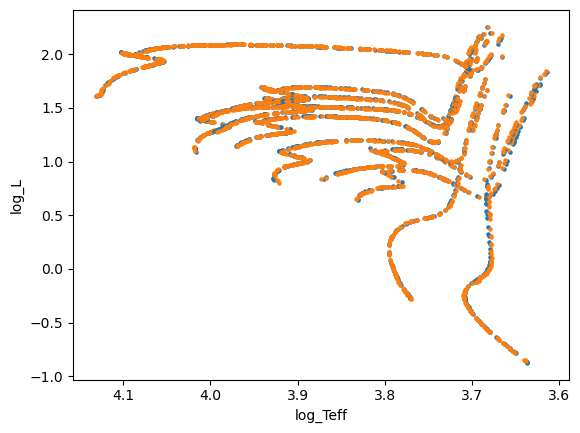

In [37]:
num_tracks = 10
random_state = 1
fig, ax = plt.subplots()
for ti in test.track.sample(num_tracks, random_state=random_state):
    mask = test.track == ti
    ax = test.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".", ax=ax)
    ax = test_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();